In [84]:
import json
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
month = [31,29,31,30,31,30,31,31,30,31,30,31]

In [10]:
with open('link_tmc_order.json', 'r') as json_file:
    link_tmcset = json.load(json_file)
with open('filtered_month_7_AM_dict.json', 'r') as json_file:
    filtered_month_7_AM_dict = json.load(json_file)
with open('link_time.json', 'r') as json_file:
    link_time = json.load(json_file)

In [45]:
def get_graph():
    #filename = argv[1]
    filename = 'highway.txt'  # single-direction graph
    graph = {}
    with open(filename) as g:
        i = 1
        for line in g:
            l = line.split()
            vertex = int(l.pop(0))
            graph[vertex] = {}
            for x in l:
                adj_vert, link = x.split(",")#map(str, x.split(","))
                graph[vertex][int(adj_vert)] = link
            #print ("Got graph. Ex: line ",i, ":", graph[i])
            i += 1
    return graph

In [49]:
def dijkstra_score_s(G, shortest_distances, v, w, t):
    name = G[v][w] + '_' + str(t[0]) + '_' + str(t[1]) + '_' + str(t[2]) + '_' + str(t[3])
    return shortest_distances[v] + float(link_time[name])

In [27]:
# dijkstra based on static cost at time t
def dijkstra_s(G, source, t):
    unprocessed = set(G.keys()) # vertices whose shortest paths from source have not yet been calculated
    unprocessed.remove(source)
    shortest_distances = {source: 0}
    shortest_route = {source: source}
 
    for i in range(len(G) - 1):
        # find a vertex with the next shortest path, i.e. minimal Dijkstra score
        m, closest_head = float('inf'), 0  #shortest distance, vertex index
        #print(shortest_distances)
        for tail in shortest_distances:
            for head in G[tail]:
                head = int(head)
                if head in unprocessed:
                    d = dijkstra_score_s(G, shortest_distances, tail, head, t)
                    if d < m:
                        m, closest_head = d, head
                        closest_nb = tail
        try:
            #print(closest_head,m,closest_nb)
            unprocessed.remove(closest_head)
            shortest_distances[closest_head] = m
            shortest_route[closest_head] = closest_nb
        except:
            break
 
    # in case G is not fully connected
    for vertex in unprocessed:
        shortest_distances[vertex] = float('inf')
 
    return [shortest_distances,shortest_route]

In [6]:
def add_time(start, time):
    start[3] += time
    #print(start)
    while start[3] > 59:
        start[2] += 1
        start[3] -= 60
        if start[2] > 23:
            start[2] -= 24
            start[1] += 1
        if start[1] > month[start[0]]:
            start[1] -= month[start[0]]
            start[0] += 1
        if start[0] > 12:
            start[0] -= 12

In [100]:
def simulator(links, start):
    time = 0  # (int) discrete sample index  
    cost = 0  # (float) real travel-time
    d_time = 0
    for link in range(len(links)):
        link_key = links[link]
        #print(link_key)
        segs = link_tmcset[link_key]
        for seg in range(len(segs)):
            add_time(start,d_time)
            seg_key = segs[seg]+'_'+str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'_'+str(start[3])
            if start[2]>8:
                #print('No data after 9:00 AM,simulate terminated!')
                #break
                cost += float(filtered_month_7_AM_dict[segs[seg]+'_'+str(start[0])+'_'+str(start[1])+'_8_59'].split('_')[1])
                continue
            try:
                cost += float(filtered_month_7_AM_dict[seg_key].split('_')[1])
            except:
                if start[3]>0:
                    seg_key = segs[seg]+'_'+str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'_'+str(start[3]-1)
                else:
                    seg_key = segs[seg]+'_'+str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'_'+str(start[3]+1) 
                cost += float(filtered_month_7_AM_dict[seg_key].split('_')[1])
            d_time = math.floor(cost - time)
            time = math.floor(cost)        
            #print(seg_key,time,cost)
            #print(seg_key,cost,time,d_time)
    return cost

In [111]:
G = get_graph()
ATA = []
ETA = []
ETA2 = []
EST_LINK = []
o = 2
d = 8
for day in range(1,32):
    for i in range(5,9):
        for j in range(60):        
            [dis,rt] = dijkstra_s(G,o,[7,day,i,j])
            #print('ETA:',dis[d])
            ETA.append(dis[d])
            #infer the route according to rt(d2o)
            route = [d]
            D = d
            while rt[D] != o:
                D = rt[D]
                route.append(D)
            route.append(o)
            # convers vector route(o2d)
            R = []
            LINK = []
            for k in range(len(route)):
                R.append(route[len(route)-1-k])
                if k:
                    LINK.append(G[route[k]][route[k-1]])
            #print('Estimated route(node by node):',R)
            #print('Estimated route(link by link):',LINK)
            ATA.append(simulator(LINK,[7,day,i,j]))
            #ETA2.append(simulator(LINK,[7,day-1,i,j]))
            EST_LINK.append(LINK)

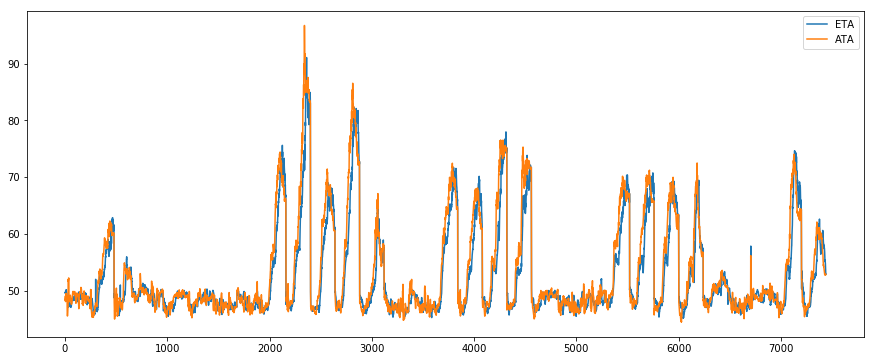

In [112]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.plot(ETA,label='ETA')
#plt.plot(ETA2,label='ETA2')
plt.plot(ATA,label='ATA')
plt.legend()
plt.show()

In [77]:
#print(ATA,ETA)
with open('result\comp.csv','w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(ETA)
    writer.writerow(ATA)

In [94]:
print(EST_LINK[100],EST_LINK[120])

['link_22', 'link_18', 'link_8', 'link_4'] ['link_22', 'link_18', 'link_8', 'link_4']
